In [49]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

# Load the file
file_path = r'C:\Users\Yash Malik\Downloads\hst_mos_0017053_acs_wfc_f555w_sci.fits'  # Adjust this
with fits.open(file_path) as hdu_list:
    # Print info about all HDUs
    print("Number of HDUs:", len(hdu_list))
    for i, hdu in enumerate(hdu_list):
        print(f"\nHDU {i}:")
        print(f"Header: {hdu.header}")
        print(f"Data type: {type(hdu.data)}")
        print(f"Data shape: {hdu.data.shape if hdu.data is not None else 'None'}")

    # Try to find the image data
    for i, hdu in enumerate(hdu_list):
        if hdu.data is not None and isinstance(hdu.data, np.ndarray):
            sci_data = hdu.data
            sci_header = hdu.header
            print(f"\nFound image data in HDU {i}:")
            print("Header Info:", sci_header)
            print("Image Shape:", sci_data.shape)
            break
    else:
        print("No image data found in any HDU.")

Number of HDUs: 2

HDU 0:
Header: SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                    8 / array data type                                NAXIS   =                    0 / number of array dimensions                     EXTEND  =                    T                                                  COMMENT   FITS (Flexible Image Transport System) format is defined in 'AstronomyCOMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H                                                                                 TELESCOP= 'HST'                / telescope used to acquire data                 INSTRUME= 'ACS   '             / identifier for instrument used to acquire data                                                                                               / DATA DESCRIPTION KEYWORDS                                                                                                                       IMAGET

Image found in HDU 1
Header Info: XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                11900                                                  NAXIS2  =                 9200                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               INHERIT =                    T / inherit the primary header                     EXTNAME = 'SCI     '           / extension name                                 EXTVER  =                    1                                                  BUNIT   = 'ELECTRONS/S'        / Units of science product                                                                                                       CD1_1 

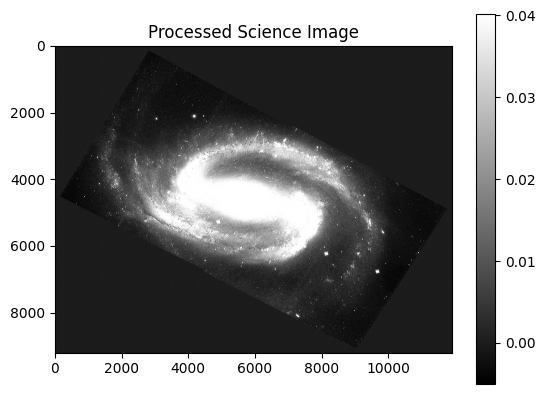

In [39]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

file_path = r'C:\Users\Yash Malik\Downloads\hst_mos_0017053_acs_wfc_f555w_sci.fits'  # Adjust this
with fits.open(file_path) as hdu_list:
    # Find the HDU with image data
    for i, hdu in enumerate(hdu_list):
        if hdu.data is not None and isinstance(hdu.data, np.ndarray):
            sci_data = hdu.data
            sci_header = hdu.header
            print(f"Image found in HDU {i}")
            print("Header Info:", sci_header)
            print("Image Shape:", sci_data.shape)
            plt.imshow(sci_data, cmap='gray', vmin=np.percentile(sci_data, 5), vmax=np.percentile(sci_data, 95))
            plt.title('Processed Science Image')
            plt.colorbar()
            plt.show()
            break
    else:
        print("No image data found in the file.")

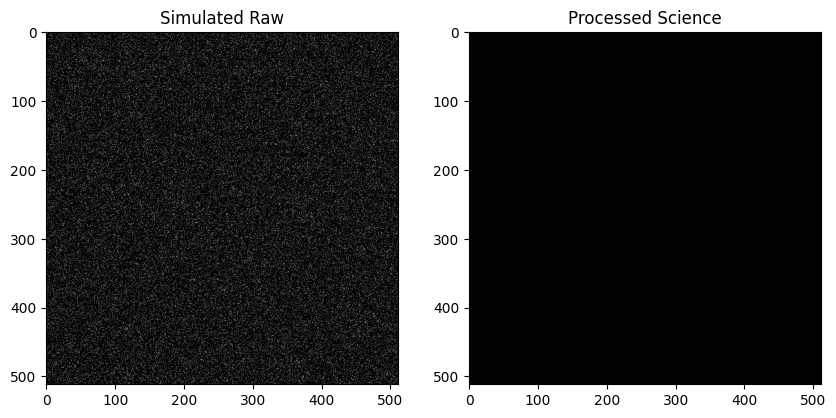

2025-03-29 21:19:19,837 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████|20/20, best_cost=0.000386
2025-03-29 21:19:25,249 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0003858751839003161, best pos: [14.34178107]


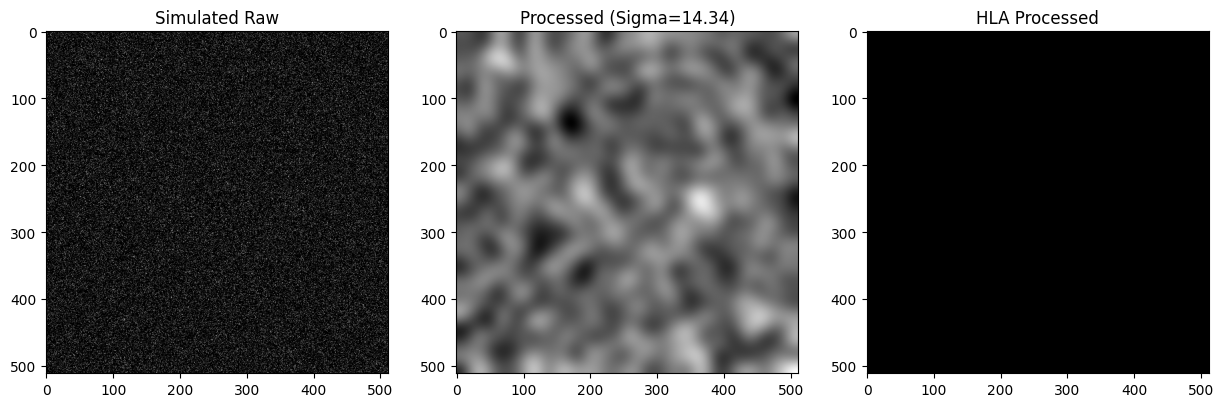

In [43]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter
import pyswarms as ps

# Load FITS file
file_path = r'C:\Users\Yash Malik\Downloads\hst_mos_0017053_acs_wfc_f555w_sci.fits'  # Adjust this
with fits.open(file_path) as hdu_list:
    for i, hdu in enumerate(hdu_list):
        if hdu.data is not None and isinstance(hdu.data, np.ndarray):
            sci_data = hdu.data
            sci_header = hdu.header
            break

# Preprocess
sci_data_normalized = (sci_data - np.min(sci_data)) / (np.max(sci_data) - np.min(sci_data))
raw_simulated = sci_data_normalized + np.random.normal(0, 0.05, sci_data.shape)
raw_simulated = np.clip(raw_simulated, 0, 1)
raw_simulated = np.nan_to_num(raw_simulated, nan=0.0, posinf=1.0, neginf=0.0)
sci_data_normalized = np.nan_to_num(sci_data_normalized, nan=0.0, posinf=1.0, neginf=0.0)
crop_size = 512
raw_simulated_cropped = raw_simulated[:crop_size, :crop_size]
sci_data_cropped = sci_data_normalized[:crop_size, :crop_size]

# Visualize before processing
plt.figure(figsize=(10, 5))
plt.subplot(121); plt.imshow(raw_simulated_cropped, cmap='gray'); plt.title('Simulated Raw')
plt.subplot(122); plt.imshow(sci_data_cropped, cmap='gray'); plt.title('Processed Science')
plt.show()

# Fitness function
def fitness(params, raw_image, ref_image):
    processed = gaussian_filter(raw_image, sigma=params[0])
    return np.mean((processed - ref_image) ** 2)

# Optimize with PSO
optimizer = ps.single.GlobalBestPSO(n_particles=10, dimensions=1, options={'c1': 0.5, 'c2': 0.3, 'w': 0.9})
best_cost, best_params = optimizer.optimize(
    lambda x: [fitness(p, raw_simulated_cropped, sci_data_cropped) for p in x], iters=20
)

# Process and visualize result
processed_image = gaussian_filter(raw_simulated_cropped, sigma=best_params[0])
plt.figure(figsize=(15, 5))
plt.subplot(131); plt.imshow(raw_simulated_cropped, cmap='gray'); plt.title('Simulated Raw')
plt.subplot(132); plt.imshow(processed_image, cmap='gray'); plt.title(f'Processed (Sigma={best_params[0]:.2f})')
plt.subplot(133); plt.imshow(sci_data_cropped, cmap='gray'); plt.title('HLA Processed')
plt.show()

In [64]:
import numpy as np
from deap import base, creator, tools
from skimage import filters

# Setup DEAP
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Quantum population
def init_quantum_population(pop_size, n_params):
    return [creator.Individual(np.random.random(n_params).tolist()) 
            for _ in range(pop_size)]

# Observation
def observe(individual):
    return [1 if p > np.random.random() else 0 for p in individual]

# Processing and fitness
def apply_processing(image, config):
    kernel_size = 3 if config[0] == 1 else 5
    threshold = 0.5 if config[1] == 1 else 0.2
    # Corrected: Use filters.median with footprint
    processed = filters.median(image, footprint=np.ones((kernel_size, kernel_size)))
    return processed > threshold

def compute_snr(processed_image):
    signal = np.mean(processed_image)
    noise = np.std(processed_image)
    return signal / noise if noise > 0 else 0

def evaluate(individual, image_data):
    config = observe(individual)
    processed_image = apply_processing(image_data, config)
    return (compute_snr(processed_image),)

# Quantum update
def update_quantum(individual, best):
    for i in range(len(individual)):
        delta = 0.05 * (observe(best)[i] - observe(individual)[i])
        individual[i] = np.clip(individual[i] + delta, 0, 1)
    return individual

# Main execution
image_data = np.random.rand(100, 100)  # Replace with FITS data
population = init_quantum_population(pop_size=50, n_params=5)

for gen in range(100):
    fitnesses = [evaluate(ind, image_data) for ind in population]
    for ind, fit in zip(population, fitnesses):
        ind.fitness.values = fit
    best = tools.selBest(population, k=1)[0]
    print(f"Gen {gen}, Best Fitness: {best.fitness.values[0]}")
    population = [update_quantum(ind, best) for ind in population]

final_best = tools.selBest(population, k=1)[0]
best_config = observe(final_best)
print("Best Configuration:", best_config)

C:\Users\Yash Malik\OneDrive\Desktop\Projects\Quantum AI based compiler for astronomical image processing\qai_compiler_env\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Yash Malik\OneDrive\Desktop\Projects\Quantum AI based compiler for astronomical image processing\qai_compiler_env\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Gen 0, Best Fitness: 44.710177812216315
Gen 1, Best Fitness: 44.710177812216315
Gen 2, Best Fitness: 44.710177812216315
Gen 3, Best Fitness: 44.710177812216315
Gen 4, Best Fitness: 44.710177812216315
Gen 5, Best Fitness: 44.710177812216315
Gen 6, Best Fitness: 44.710177812216315
Gen 7, Best Fitness: 44.710177812216315
Gen 8, Best Fitness: 44.710177812216315
Gen 9, Best Fitness: 44.710177812216315
Gen 10, Best Fitness: 44.710177812216315
Gen 11, Best Fitness: 44.710177812216315
Gen 12, Best Fitness: 44.710177812216315
Gen 13, Best Fitness: 44.710177812216315
Gen 14, Best Fitness: 44.710177812216315
Gen 15, Best Fitness: 44.710177812216315
Gen 16, Best Fitness: 44.710177812216315
Gen 17, Best Fitness: 44.710177812216315
Gen 18, Best Fitness: 44.710177812216315
Gen 19, Best Fitness: 44.710177812216315
Gen 20, Best Fitness: 44.710177812216315
Gen 21, Best Fitness: 44.710177812216315
Gen 22, Best Fitness: 44.710177812216315
Gen 23, Best Fitness: 44.710177812216315
Gen 24, Best Fitness: 44.7